# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete some of the cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the locked cells, you may follow the instructions at the bottom of this notebook._

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



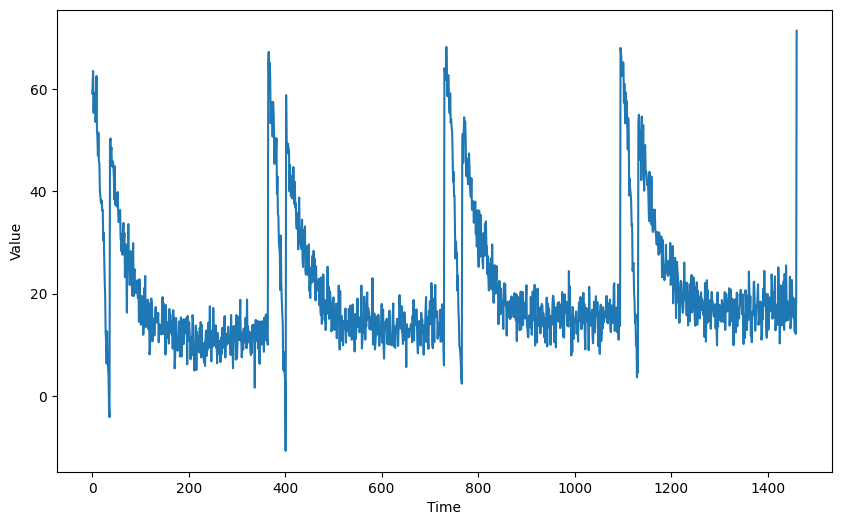

In [46]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [47]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [48]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below. 

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [49]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [50]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

e:\WD\projects\personal\monev\rnn\.venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Your current architecture is compatible with the windowed dataset! :)


C:\Users\Vito\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [51]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [52]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 59.9642 - mae: 60.4615 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8569 - mae: 17.3456 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2140 - mae: 8.7022 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8800 - mae: 6.3545 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1023 - mae: 6.5797 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2630 - mae: 5.7417 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7466 - mae: 5.2241 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8300 - mae: 5.3042 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9037 - mae: 4.3728 - learning_rate: 2.5119e-06
Epoch 10/100
34/34 ━━━━━

(1e-06, 1.0, 0.0, 30.0)

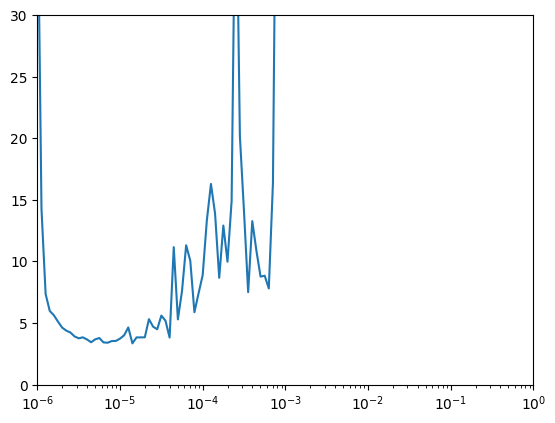

In [53]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [54]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=6e-6, momentum=0.9),
                  metrics=["mae"])   
    
    ### END CODE HERE

    return model

In [55]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 42.8864 - mae: 43.3846
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3790 - mae: 7.8580 
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9944 - mae: 6.4693
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6368 - mae: 5.1116
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7900 - mae: 4.2545
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0115 - mae: 4.4831
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7564 - mae: 4.2261
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2825 - mae: 3.7436
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3240 - mae: 3.7897
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2852 - mae: 3.7545
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1912 - mae: 3.6604
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9133 - mae: 4.3850
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

## Evaluating the forecast

In [56]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


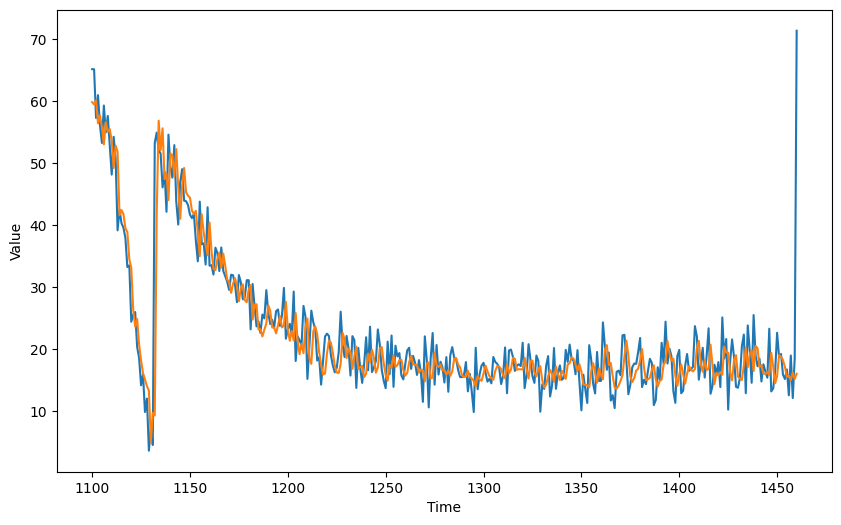

In [57]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>